<a href="https://colab.research.google.com/github/marianne-b/GeneticDrawing/blob/main/notebooks/projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Chargement des bibliothèques nécessaires au traitement de l'image et à l'affichage

import cv2  # OpenCV : traitement d'images (chargement, conversion, filtrage, etc.)
import numpy as np  # NumPy : manipulation de tableaux multidimensionnels
import time  # time : gestion du temps (utile pour la génération de graines pseudo-aléatoires)
import matplotlib.pyplot as plt  # Matplotlib : affichage d’images et de courbes
from IPython.display import clear_output  # Nettoyage dynamique de l'affichage dans un notebook Jupyter

# Bibliothèques supplémentaires

import os  # os : gestion des fichiers et répertoires
import random  # random : génération de nombres aléatoires
import colorsys  # colorsys : conversion entre différents espaces colorimétriques (HSV, RGB, etc.)

In [ ]:
class DessinGenetique:
    def __init__(self, imageChargee, seed=0, plagePinceaux=[[0.1, 0.3], [0.3, 0.7]]):
        """
        Initialise la classe avec une image, une graine pour l'aléatoire et une plage de tailles de pinceaux.
        Prépare aussi une toile blanche et calcule le gradient de l'image.
        """
        self.imageOriginale = cv2.imread(imageChargee)
        self.imageCouleur = cv2.cvtColor(self.imageOriginale, cv2.COLOR_BGR2RGB)
        self.imageGradient = self._imgGradient(self.imageCouleur)
        self.monADN = None
        self.seed = seed
        self.plagePinceaux = plagePinceaux
        self.mask = None

        # Créer une toile blanche de la même dimension que l'image
        self.toile = [np.zeros((self.imageCouleur.shape[0], self.imageCouleur.shape[1],3), np.uint8)]

    def generer(self, etapes=10, generations=100, nbCoupsPinceaux=10, montrerEvolution=True):
        """
        Gère le processus évolutif en plusieurs étapes et générations pour produire une image peinte à partir de l'image cible.
        """
        for s in range(etapes):
            # Initialiser l'ADN de la peinture
            if self.mask is not None:
                mask = self.mask
            else:
                mask = self.creer_mask(s, etapes)
            self.monADN = ADN_Peinture(self.imageCouleur.shape[0:2],
                                       self.imageGradient,
                                       self.calculerTaillePinceaux(s, etapes),
                                       toile=self.toile[-1],
                                       mask=mask)
            self.monADN.initialisationAleatoire(self.imageCouleur, nbCoupsPinceaux, self.seed + time.time() + s)

            # Évolution de l'ADN pour cette étape
            for g in range(generations):
                self.monADN.evoluerDNASeq(self.imageCouleur, self.seed + time.time() + g)
                clear_output(wait=True)
                print("Étape ", s + 1, ". Génération ", g + 1, "/", generations)
                if montrerEvolution is True:
                    plt.imshow(self.monADN.get_cached_image())
                    plt.show()

            self.toile.append(self.monADN.get_cached_image())
        return self.monADN.get_cached_image()

    def calculerTaillePinceaux(self, etape, totalEtapes):
        """
        Calcule la plage de tailles de pinceaux en fonction de l'étape actuelle.
        """
        return [self.calculerTailleBroche(self.plagePinceaux[0], etape, totalEtapes),
                self.calculerTailleBroche(self.plagePinceaux[1], etape, totalEtapes)]

    def definirPlagePinceaux(self, ranges):
        """
        Permet de modifier manuellement la plage de tailles de pinceaux.
        """
        self.plagePinceaux = ranges

    def initialisationMask(self, imageChargee):
        """
        Charge une image et la convertit pour être utilisée comme masque.
        """
        self.mask = cv2.cvtColor(cv2.imread(imageChargee), cv2.COLOR_BGR2RGB)

    def creer_mask(self, etape, totalEtapes):
        """
        Génère dynamiquement un masque progressif à partir de l’image couleur.
        Plus l’étape est avancée, plus le masque est concentré sur des détails fins.
        """
        pourcentage = 0.2  # on attend 20% des étapes avant d’introduire le masque
        debut = int(totalEtapes * pourcentage)

        if etape >= debut:
            # Réduction progressive du flou pour plus de précision au fil des étapes
            t = (1.0 - (etape - debut) / max(totalEtapes - debut - 1, 1)) * 0.25 + 0.005
            return self.calculer_mask(t)

        return None


    def _imgGradient(self, img):
        """
        Calcule la magnitude et l'orientation du gradient à partir du canal de luminosité de l'image.
        """
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        v_channel = np.float32(hsv[:, :, 2]) / 255.0  # Normalisation

        gx = cv2.Sobel(v_channel, cv2.CV_32F, 1, 0, ksize=1)
        gy = cv2.Sobel(v_channel, cv2.CV_32F, 0, 1, ksize=1)

        mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
        mag /= np.max(mag) + 1e-8  # éviter division par zéro
        mag = np.power(mag, 0.3)  # Réduire le contraste
        return mag, angle



    def calculer_mask(self, pourcentage_flou):
        """
        Calcule un masque basé sur :
        - la magnitude du gradient de luminosité (canal V de HSV)
        - la saturation (zones colorées riches)
        Ce masque est flouté pour guider les coups de pinceaux vers les détails pertinents.
        """
        hsv = cv2.cvtColor(self.imageCouleur, cv2.COLOR_RGB2HSV)
        v = np.float32(hsv[:, :, 2]) / 255.0  # canal V (luminosité)
        s = np.float32(hsv[:, :, 1]) / 255.0  # canal S (saturation)

        # Gradient de la luminosité
        gx = cv2.Sobel(v, cv2.CV_32F, 1, 0, ksize=1)
        gy = cv2.Sobel(v, cv2.CV_32F, 0, 1, ksize=1)
        mag, _ = cv2.cartToPolar(gx, gy)

        # Pondérer avec la saturation (met en avant les zones colorées ET contrastées)
        masque = mag * s

        # Appliquer un flou gaussien selon la taille de l’image
        sigma = self.imageCouleur.shape[0] * pourcentage_flou
        if sigma > 1:
            masque = cv2.GaussianBlur(masque, (0, 0), sigma)

        # Normaliser sur 255
        masque_normalise = (masque / (masque.max() + 1e-8)) * 255.0
        return masque_normalise


    def calculerTailleBroche(self, plage, etape, totalEtapes):
        """
        Interpole la taille d’un pinceau en fonction de l’étape courante.
        Utilise une décroissance quadratique pour affiner progressivement.
        """
        bmin = plage[0]
        bmax = plage[1]
        t = etape / max(totalEtapes - 1, 1)
        return (bmax - bmin) * (-t * t + 1) + bmin


def util_sample_from_img(img):
    """
    Tire au sort une position dans l’image, pondérée par l’intensité (valeurs plus élevées ont plus de chance).
    Fonction utilisée pour guider les coups de pinceaux vers les zones importantes.
    """
    # Forcer en niveaux de gris si l'image est en couleur
    if img.ndim == 3:
        img = np.mean(img, axis=2)

    # Générer toutes les positions possibles (x, y)
    pos = np.indices(dimensions=img.shape[0:2])
    pos = pos.reshape(2, pos.shape[1]*pos.shape[2])

    # Aplatir l'image et normaliser les intensités pour créer une distribution de probabilités
    img_flat = np.clip(img.flatten() / img.flatten().sum(), 0.0, 1.0)

    # Retourner une position choisie aléatoirement selon la distribution
    return pos[:, np.random.choice(np.arange(pos.shape[1]), 1, p=img_flat)]


class ADN_Peinture:

    def __init__(self, limite, imgGradient, plagePinceaux, toile=None, mask=None):
        """
        Initialise les paramètres de l'ADN : taille de l'image, plage des pinceaux, gradients,
        toile de fond, masque éventuel, pinceaux chargés, et les caches pour l’image et l’erreur.
        """
        self.sequenceADN = []
        self.limite = limite  # dimensions de l'image (hauteur, largeur)

        # Paramètres de contrôle
        self.tailleMinimale = plagePinceaux[0]
        self.tailleMaximale = plagePinceaux[1]
        self.nbBrochesMaximales = 4  # nombre de pinceaux maximum
        self.cotePinceau = 10  # taille de base des pinceaux en pixels
        self.padding = int(self.cotePinceau * self.tailleMaximale / 2 + 5)  # marge de sécurité

        self.toile = toile

        # Gradient de l'image cible
        self.imgMag = imgGradient[0]
        self.imgAngles = imgGradient[1]

        # Pinceaux et masque
        self.pinceaux = self.prechargerPinceaux('brushes/watercolor/', self.nbBrochesMaximales)
        self.mask = mask

        # Cache de l’image générée et de l’erreur
        self.imageCachee = None
        self.erreurCachee = None

    def prechargerPinceaux(self, chemin, maxBrushNumber):
        """
        Charge en mémoire les pinceaux depuis le dossier donné.
        """
        pinceaux = []
        for i in range(maxBrushNumber):
            pinceaux.append(cv2.imread(chemin + str(i) + '.jpg'))
        return pinceaux

    def genererNouvellesPositions(self):
        """
        Génère une position aléatoire dans l'image.
        Si un masque est fourni, privilégie les zones à forte intensité du masque.
        """
        if self.mask is not None:
            pos = util_sample_from_img(self.mask)
            posY = pos[0][0]
            posX = pos[1][0]
        else:
            posY = int(random.randrange(0, self.limite[0]))
            posX = int(random.randrange(0, self.limite[1]))
        return [posY, posX]

    def initialisationAleatoire(self, imageCible, compte, seed):
        """
        Initialise aléatoirement une séquence d'ADN composée de coups de pinceaux,
        en fonction de l'image cible, du gradient et de la graine.
        """
        for i in range(compte):
            random.seed(seed - i + 4)
            taille = random.random() * (self.tailleMaximale - self.tailleMinimale) + self.tailleMinimale
            posY, posX = self.genererNouvellesPositions()
            couleur = imageCible[posY, posX].tolist()
            localMag = self.imgMag[posY][posX]
            localAngle = self.imgAngles[posY][posX] + 90  # perpendiculaire à l'orientation du gradient
            rotation = random.randrange(-180, 180) * (1 - localMag) + localAngle
            numeroPinceau = random.randrange(1, self.nbBrochesMaximales)
            self.sequenceADN.append([couleur[0], couleur[1], couleur[2], posY, posX, taille, rotation, numeroPinceau])

        # Mise à jour du cache d'erreur et d'image
        self.erreurCachee, self.imageCachee = self.calculerErreurTotale(imageCible)

    def get_cached_image(self):
        """
        Retourne l’image actuellement générée (mise en cache).
        """
        return self.imageCachee

    def calculerErreurTotale(self, imageEntree):
        """
        Calcule l’erreur entre l’image générée et l’image cible.
        """
        return self.__calculerErreur(self.sequenceADN, imageEntree)

    def __calculerErreur(self, sequenceADN, imageEntree):
        """
        Dessine la séquence ADN et compare pixel par pixel avec l’image cible.
        Retourne la somme des différences (erreur) et l’image générée.
        """
        monImage = self.dessinerTout(sequenceADN)

        if imageEntree.shape != monImage.shape:
            raise ValueError(f"Dimensions mismatch: {imageEntree.shape} vs {monImage.shape}")

        if imageEntree.dtype != np.uint8:
            imageEntree = np.clip(imageEntree, 0, 255).astype(np.uint8)
        if monImage.dtype != np.uint8:
            monImage = np.clip(monImage, 0, 255).astype(np.uint8)

        diff1 = cv2.subtract(imageEntree, monImage)
        diff2 = cv2.subtract(monImage, imageEntree)
        diffTotale = cv2.add(diff1, diff2)
        diffTotale = np.sum(diffTotale)

        return (diffTotale, monImage)

    def dessiner(self):
        """
        Dessine l’image finale à partir de la séquence actuelle d’ADN.
        """
        monImage = self.dessinerTout(self.sequenceADN)
        return monImage

    def dessinerTout(self, sequenceADN):
        """
        Dessine tous les coups de pinceaux contenus dans une séquence ADN
        sur une toile (soit vide soit fournie).
        """
        if self.toile is None:
            imageEntree = np.zeros((self.limite[0], self.limite[1], 3), np.uint8)
        else:
            imageEntree = np.copy(self.toile)

        p = self.padding
        imageEntree = cv2.copyMakeBorder(imageEntree, p, p, p, p, cv2.BORDER_CONSTANT, value=[0, 0, 0])

        for i in range(len(sequenceADN)):
            imageEntree = self.__dessinerADN(sequenceADN[i], imageEntree)

        y = imageEntree.shape[0]
        x = imageEntree.shape[1]
        return imageEntree[p:(y - p), p:(x - p)]

    def __dessinerADN(self, ADN, imageEntree):
        """
        Applique un coup de pinceau (défini par un gène de l’ADN) sur l’image en cours.
        Gère le positionnement, la taille, la rotation, la coloration et le mélange alpha.
        """
        # Décomposer les paramètres du gène
        couleur = [ADN[0], ADN[1], ADN[2]]
        posX = int(ADN[4]) + self.padding
        posY = int(ADN[3]) + self.padding
        taille = ADN[5]
        rotation = ADN[6]
        numeroPinceau = int(ADN[7])

        # Charger et redimensionner le pinceau
        pinceauImg = self.pinceaux[numeroPinceau]
        pinceauImg = cv2.resize(pinceauImg, None, fx=taille, fy=taille, interpolation=cv2.INTER_CUBIC)

        # Appliquer la rotation
        pinceauImg = self.__rotateImg(pinceauImg, rotation)

        # Générer un pinceau coloré à partir de la texture et de la couleur
        pinceauColori = np.zeros_like(pinceauImg, dtype=np.uint8)
        lum = cv2.cvtColor(pinceauImg, cv2.COLOR_BGR2GRAY) / 255.0  # intensité de la brosse

        for c in range(3):
            pinceauColori[:, :, c] = np.clip(couleur[c] * lum, 0, 255)

        # Déterminer la zone de destination sur la toile
        h, w = pinceauImg.shape[:2]
        yMin = posY - h // 2
        yMax = yMin + h
        xMin = posX - w // 2
        xMax = xMin + w

        image_rows, image_cols = imageEntree.shape[:2]

        # Gérer les dépassements de bord
        yMinClamped = max(0, yMin)
        yMaxClamped = min(image_rows, yMax)
        xMinClamped = max(0, xMin)
        xMaxClamped = min(image_cols, xMax)

        if yMinClamped >= yMaxClamped or xMinClamped >= xMaxClamped:
            return imageEntree  # Rien à dessiner

        # Déterminer la zone utile dans le pinceau
        brush_y_min = yMinClamped - yMin
        brush_y_max = brush_y_min + (yMaxClamped - yMinClamped)
        brush_x_min = xMinClamped - xMin
        brush_x_max = brush_x_min + (xMaxClamped - xMinClamped)

        # Récupérer les zones du pinceau et de l’image
        foreground = pinceauColori[brush_y_min:brush_y_max, brush_x_min:brush_x_max].astype(float)
        background = imageEntree[yMinClamped:yMaxClamped, xMinClamped:xMaxClamped].astype(float)
        alpha = lum[brush_y_min:brush_y_max, brush_x_min:brush_x_max][..., np.newaxis]

        # Mélange alpha (transparence)
        outImage = np.clip(foreground * alpha + background * (1.0 - alpha), 0, 255).astype(np.uint8)

        # Mise à jour de l’image
        imageEntree[yMinClamped:yMaxClamped, xMinClamped:xMaxClamped] = outImage

        return imageEntree

    def __rotateImg(self, img, angle):
        """
        Applique une rotation à une image selon l’angle donné autour de son centre.
        """
        rows, cols, channels = img.shape
        M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
        dst = cv2.warpAffine(img, M, (cols, rows))
        return dst

    def __evolveDNA(self, index, inImg, seed):
        """
        Applique une mutation à un gène de la séquence ADN.
        Si l'image mutée est meilleure (erreur plus faible), remplace le gène d'origine.
        """
        # Copier la séquence ADN
        DNASeqCopy = np.copy(self.sequenceADN)
        enfant = DNASeqCopy[index]

        # Sélectionner aléatoirement quels éléments muter
        random.seed(seed + index)
        optionsIndex = [0, 1, 2, 3, 4, 5, 6, 7]
        indicesChangement = []
        nombreChangements = random.randrange(1, len(optionsIndex) + 1)

        for i in range(nombreChangements):
            random.seed(seed + index + i + nombreChangements)
            indexPourPrendre = random.randrange(0, len(optionsIndex))
            indicesChangement.append(optionsIndex.pop(indexPourPrendre))

        indicesChangement.sort(reverse=True)

        # Appliquer les mutations
        for indexChangement in indicesChangement:
            if indexChangement in [0, 1, 2]:  # Couleur
                enfant[0] = int(random.randrange(0, 255))
                enfant[1] = int(random.randrange(0, 255))
                enfant[2] = int(random.randrange(0, 255))
            elif indexChangement in [3, 4]:  # Position
                enfant[3], enfant[4] = self.genererNouvellesPositions()
            elif indexChangement == 5:  # Taille
                enfant[5] = random.random() * (self.tailleMaximale - self.tailleMinimale) + self.tailleMinimale
            elif indexChangement == 6:  # Rotation
                localMag = self.imgMag[int(enfant[3])][int(enfant[4])]
                localAngle = self.imgAngles[int(enfant[3])][int(enfant[4])] + 90
                enfant[6] = random.randrange(-180, 180) * (1 - localMag) + localAngle
            elif indexChangement == 7:  # Numéro de pinceau
                enfant[7] = random.randrange(1, self.nbBrochesMaximales)

        # Évaluer l’enfant et accepter la mutation si meilleure
        erreur_enfant, image_enfant = self.__calculerErreur(DNASeqCopy, inImg)
        if erreur_enfant < self.erreurCachee:
            self.sequenceADN[index] = enfant[:]
            self.cached_image = image_enfant
            self.cached_error = erreur_enfant

    def evoluerDNASeq(self, inImg, seed):
        """
        Fait évoluer toute la séquence ADN en appliquant une mutation à chaque gène.
        """
        for i in range(len(self.sequenceADN)):
            self.__evolveDNA(i, inImg, seed)


Étape  100 . Génération  3 / 3


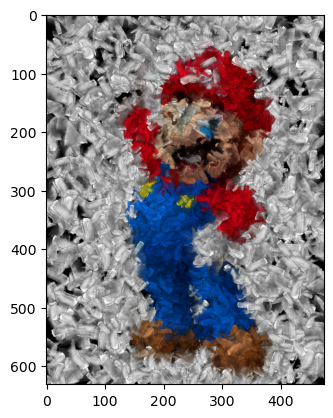

In [ ]:
# Charger une image d'exemple et initialiser le générateur de dessin génétique

gen = DessinGenetique('mario.jpg', seed=time.time())
# Crée une instance de DessinGenetique avec l’image "mario.jpg" et une graine aléatoire basée sur l’heure actuelle

#gen.plagePinceaux = [[0.1, 0.3], [0.3, 0.7]]
gen.plagePinceaux = [[0.15, 0.25], [0.03, 0.07]]


# Définir une nouvelle plage de tailles de pinceaux : plus petite (entre 5% et 10%) et moyenne (entre 10% et 20%)

out = gen.generer(etapes=100, generations=3, nbCoupsPinceaux=40)
# Lancer la génération avec 100 étapes, mais seulement 1 génération d’évolution par étape
# Cela permet de voir rapidement une ébauche du processus sans optimisation prolongée


Étape  40 . Génération  3 / 3


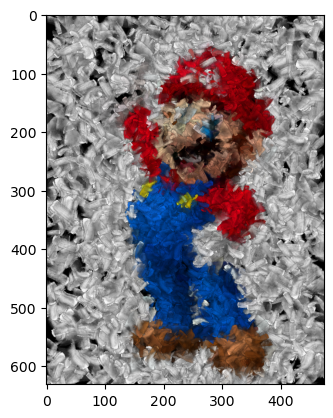

In [ ]:
# Charger un masque personnalisé et définir une taille de pinceau plus petite pour des détails plus fins

gen.sampling_mask = cv2.cvtColor(cv2.imread("maskmario.png"), cv2.COLOR_BGR2RGB)
# Charge une image de masque ("mask.jpg") et la convertit en RGB pour guider les futures touches de pinceau

gen.plagePinceaux = [[0.08, 0.12], [0.02, 0.05]]
# Redéfinit la plage des tailles de pinceaux pour plus de précision (petits coups de pinceau)

# Continuer à dessiner par-dessus le résultat précédent
out = gen.generer(40, 3)
# Ajoute 40 étapes supplémentaires avec 1 génération chacune, en conservant la toile précédente

In [ ]:
# Vérifie si le dossier de sortie existe, sinon le crée
if not os.path.exists('out'):
    os.mkdir("out")

# Parcourt toutes les images dans gen.toile
for i in range(len(gen.toile)):
    image = gen.toile[i]

    # Vérifie si l'image est en couleur (3 canaux)
    if image.shape[2] == 3:
        # Convertit l'image de RGB à BGR
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Sauvegarde l'image
    cv2.imwrite(os.path.join("out", f"{i:06d}.png"), image)

#if you want to save only last image, run below
# cv2.imwrite("out/final.png', out)